In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS


In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 1.0        
	path                   : /Users/ASinha/opt/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy 



In [4]:
print(CATALOG_REGISTRY)
catalog=SourceCatalogHGPS()
source = catalog[3]

model = source.sky_model()
print(model)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

SkyModel

  Name                      : HESS J1018-589 B
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.196   +/-    0.09             
    amplitude                     :   9.15e-14   +/- 1.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      2.742       TeV         
    lon_0                         :    284.223   +/-    0.04 deg         
    lat_0                         :     -1.772   +/-    0.03 deg         
    sigma                         :      0.150   +/-    0.03 deg         
    e                     (frozen):      0.000                  

In [5]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [8]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)


In [59]:
def simulate_range():
    list_model=[]
    
    spectral_model=PowerLawSpectralModel(
        amplitude="1e-12 cm-2 s-1 TeV-1", index=2, reference="1 TeV"
    )
    spatial_model=GaussianSpatialModel(
        lon_0="0.4 deg", lat_0="-0.6 deg", frame="galactic"  
    )
    spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
    spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
    spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
    spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5
    for rad in [0.1]:
        spatial_model.sigma.value=rad
        model = SkyModel(spectral_model, spatial_model)
        list_model.append(model)
    return list_model

In [60]:
list_model=simulate_range()

In [61]:
def fit_dataset(model,vary_bkg=False):
    
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
 
    bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
    if vary_bkg==True:
        bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
        bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
        
    # A faint diffuse background
    #diffuse_spec = PowerLawSpectralModel()
    #diffuse_spec.index.value = 2.7
    #diffuse_spec.amplitude.value = 1e-13
    #diffuse_spat = GaussianSpatialModel()
    #diffuse_spat = GaussianSpatialModel(frame="galactic")
    #diffuse_spat.sigma.value = 1.0
    #diffuse_spat.e.value = 0.99999
    #diffuse_spat.phi.value = 90
    #diffuse_model = SkyModel(spectral_model=diffuse_spec,
    #                         spatial_model=diffuse_spat,
    #                         name="diffuse")
        
    dataset.models =  Models([bkg_model, model])
    dataset.fake()
    # -- like an observation
    
    dataset.models = Models([bkg_model]) #  background + diffuse
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L0 = result.total_stat
    print(L0)
   
    dataset.models = Models([bkg_model, model])
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L1 = result.total_stat
    print(L1)
    return L0-L1, result, dataset

In [73]:
models=[]
TS = []
for i in range(len(list_model)):
    delt, mod, ds = fit_dataset(list_model[i],vary_bkg=False) 
    models.append(mod)
    TS.append(delt)
    
    

Position <SkyCoord (Galactic): (l, b) in deg
    (354.79227393, 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (354.79227393, 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (350.98755158, 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (350.98755158, 0.)> is outside valid IRF map range, using nearest IRF defined within


W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the m

Position <SkyCoord (Galactic): (l, b) in deg
    (355.72547979, 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (355.72547979, 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (355.39988626, -0.00232098)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (355.39988626, -0.00232098)> is outside valid IRF map range, using nearest IRF defined within


W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line


Position <SkyCoord (Galactic): (l, b) in deg
    (355.53911188, -39.56546097)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (355.53911188, -39.56546097)> is outside valid IRF map range, using nearest IRF defined within


W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0357382 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -1.25793
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -3.33508e-11
W MnPosDef non-positive diagonal element in covariance matrix[ 10 ] = -0.323548
W MnPosDef Added to diagonal of Error matrix a value 1.75793
W MnPosDef Matrix forced pos-def by adding to diagonal 1.61516
W VariableMetricBuilder gdel = -6.27844e+08
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W MnHesse 2nd derivative zero for parameter par_006_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No convergence; Edm 0.00864838 is above tolerance 0.002
W MnHesse 2nd derivative zero for parameter par_006_index ; MnHesse fails

In [77]:
delt

1135.9935278472258

In [78]:
for _ in mod.models:
    print(_.name)
    print(_.parameters.to_table())

dataset-simu-bkg
  type      name     value    unit   error   min max frozen is_norm link
-------- --------- ---------- ---- --------- --- --- ------ ------- ----
spectral      norm 1.0013e+00            nan nan nan  False    True     
spectral      tilt 0.0000e+00      0.000e+00 nan nan   True   False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True   False     
KjBOfS-0
  type      name      value         unit      ... frozen is_norm link
-------- --------- ----------- -------------- ... ------ ------- ----
spectral     index  2.0180e+00                ...  False   False     
spectral amplitude  1.1674e-12 cm-2 s-1 TeV-1 ...  False    True     
spectral reference  1.0000e+00            TeV ...   True   False     
 spatial     lon_0  4.0249e-01            deg ...  False   False     
 spatial     lat_0 -5.9904e-01            deg ...  False   False     
 spatial     sigma  9.7679e-02            deg ...  False   False     
 spatial         e  0.0000e+00                ...

<WCSAxesSubplot: >

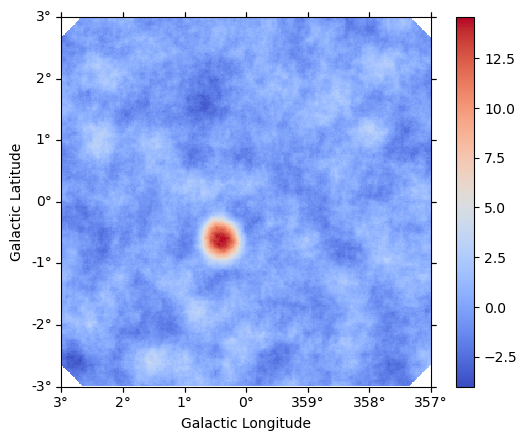

In [79]:
dataset = ds.copy()
dataset.models = None
from gammapy.estimators import *
est = ExcessMapEstimator(correlation_radius=0.3*u.deg)
res = est.run(dataset)
res["sqrt_ts"].plot(add_cbar=True, cmap="coolwarm")

In [72]:
dataset

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x1736cdb20>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x1736bb340>)temporal_model=None)

In [22]:
sigma=[]
def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)
for i in range(len(list2)):
    sigma.append(ts_to_sigma(list2[i],6))
print(sigma)

[0.0, 0.0, 0.0]


In [19]:
TS

[115.46783472667448, 165.65433917811606, 170.4594490742311]

<WCSAxesSubplot: >

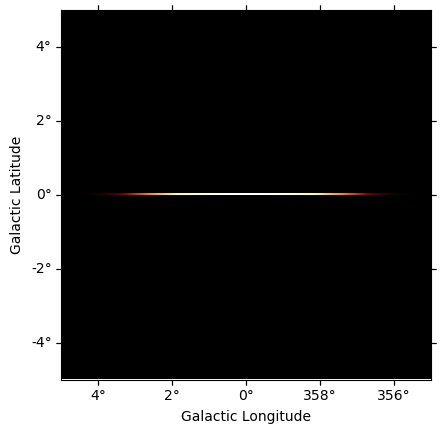

In [47]:
diffuse_spat = GaussianSpatialModel(frame="galactic")
diffuse_spat.sigma.value = 1.0
diffuse_spat.e.value = 0.99999
diffuse_spat.phi.value = 90
diffuse_spat.plot(stretch="log")